In [6]:
from pathlib import Path

from IPython.display import Audio
from torch_audiomentations import AddColoredNoise, Gain, PitchShift#, TimeStretch
import matplotlib.pyplot as plt
import torch

from processing.dataset import AudioDataset

In [7]:
bark = list(Path("data/processed/bark").glob("*.wav"))
no_bark = list(Path("data/processed/no_bark").glob("*.wav"))
dataset = AudioDataset(
    file_paths=bark + no_bark,
    labels=[1] * len(bark) + [0] * len(no_bark),
)

In [8]:
audio1 = dataset._load_audio(bark[10])
Audio(data=audio1, rate=16000)

In [9]:
audio2 = dataset._load_audio(no_bark[4000])
Audio(data=audio2, rate=16000)

In [10]:
mixed = dataset._combine_waveforms(audio1, audio2, 0.4)
Audio(data=mixed, rate=16000)

AttributeError: 'numpy.ndarray' object has no attribute 'abs'

In [15]:
from transformers import AutoModelForAudioClassification

model = AutoModelForAudioClassification.from_pretrained("facebook/wav2vec2-base", num_labels=1, problem_type="single_label_classification")

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
model

Wav2Vec2ForSequenceClassification(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)


In [29]:
model.feature_extractor._freeze_parameters()

AttributeError: 'Wav2Vec2ForSequenceClassification' object has no attribute 'feature_extractor'

In [31]:
model.wav2vec2

Wav2Vec2Model(
  (feature_extractor): Wav2Vec2FeatureEncoder(
    (conv_layers): ModuleList(
      (0): Wav2Vec2GroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): Wav2Vec2FeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Wav2Vec2Encoder(
    (pos_conv_embed): Wav2Vec2PositionalConvEmbedding(
  

In [11]:
data = torch.tensor([audio1, audio2])
data

/tmp/ipykernel_17363/1779699994.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  data = torch.tensor([audio1, audio2])


tensor([[-3.0518e-05, -1.8311e-04, -3.6621e-04,  ...,  1.5259e-04,
          1.2207e-04,  6.1035e-05],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.5564e-03,
          2.1820e-02,  1.9684e-02]])

In [32]:
list(data)

[tensor([-3.0518e-05, -1.8311e-04, -3.6621e-04,  ...,  1.5259e-04,
          1.2207e-04,  6.1035e-05]),
 tensor([ 0.0000,  0.0000,  0.0000,  ..., -0.0016,  0.0218,  0.0197])]

In [28]:
model.config.feat_extract_norm

'group'

In [25]:
from transformers import AutoFeatureExtractor

processor = AutoFeatureExtractor.from_pretrained("facebook/wav2vec2-base", return_attention_mask=True)

In [26]:
inputs = processor([audio1, audio2], sampling_rate=16000, max_length=16000, return_tensors="pt", padding="max_length", truncation=True)
inputs["input_values"].shape

torch.Size([2, 16000])

In [27]:
inputs.attention_mask

tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)

In [35]:
model(inputs.input_values).logits.squeeze(1)

tensor([-0.0402, -0.0057], grad_fn=<SqueezeBackward1>)

In [16]:
a = inputs.input_values[0]
a.shape

(2, 16000)

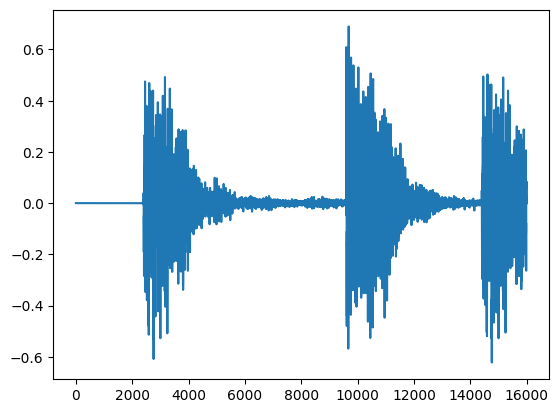

In [6]:
plt.plot(audio2)
plt.show()
Audio(data=audio2, rate=16000)

In [7]:
gained = Gain(min_gain_in_db=-20, max_gain_in_db=20, p=1.0)(audio2, sample_rate=16000)
plt.plot(gained)
plt.show()
Audio(data=gained, rate=16000)

/home/simonexc/Documents/GitHub/DogBarkClassifier/.venv/lib/python3.13/site-packages/torch_audiomentations/core/transforms_interface.py:76: FutureWarning: Transforms now expect an `output_type` argument that currently defaults to 'tensor', will default to 'dict' in v0.12, and will be removed in v0.13. Make sure to update your code to something like:
  >>> augment = Gain(..., output_type='dict')
  >>> augmented_samples = augment(samples).samples
  warnings.warn(


RuntimeError: torch-audiomentations expects three-dimensional input tensors, with dimension ordering like [batch_size, num_channels, num_samples]. If your audio is mono, you can use a shape like [batch_size, 1, num_samples].

In [8]:
stretched = TimeStretch(min_rate=0.6, max_rate=1.4, leave_length_unchanged=True, p=1.0)(audio2, sample_rate=16000)
plt.plot(stretched)
plt.show()
Audio(data=stretched, rate=16000)

NameError: name 'TimeStretch' is not defined

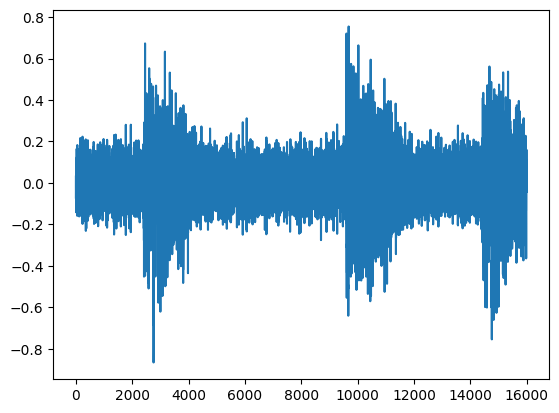

In [51]:
gaussian = AddColoredNoise(min_snr_in_db=3, max_snr_in_db=3, p=1.0)(torch.tensor(audio2).reshape(1, 1, -1), sample_rate=16000).flatten().numpy()
plt.plot(gaussian)
plt.show()
Audio(data=gaussian, rate=16000)

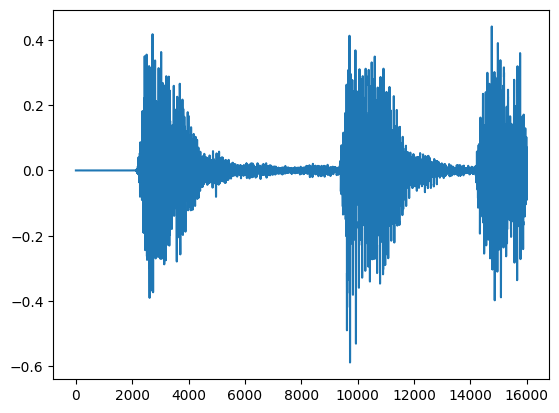

In [53]:
pitch_shift = PitchShift(min_transpose_semitones=-4, max_transpose_semitones=4, p=1.0, sample_rate=16000)(torch.tensor(audio2).reshape(1, 1,-1), sample_rate=16000).reshape(-1).numpy()
plt.plot(pitch_shift)
plt.show()
Audio(data=pitch_shift, rate=16000)

In [11]:
spectrogram = dataset.mel_spectrogram(torch.tensor(mixed))
plt.imshow(spectrogram.numpy(), origin="lower", aspect="auto", cmap="viridis")
plt.show()

AttributeError: 'AudioDataset' object has no attribute 'mel_spectrogram'

In [13]:
ampl = dataset.amplitude_to_db(spectrogram)
plt.imshow(ampl.numpy(), origin="lower", aspect="auto", cmap="viridis")
plt.show()

AttributeError: 'AudioDataset' object has no attribute 'amplitude_to_db'

In [24]:
ampl.min()

tensor(-22.8531)

In [25]:
ampl.shape

torch.Size([64, 32])

In [32]:
from inference import ModelInference

infer = ModelInference("/home/simonexc/Documents/GitHub/DogBarkClassifier/checkpoints_bark_detector_2d_v23/best_model.pth", threshold=0.759)#0.892)

In [33]:
infer.inference(audio1)

(True, 0.9960612654685974)

In [34]:
infer.inference(mixed)

(False, 0.03956223651766777)

In [29]:
infer.inference(audio2)

(False, 0.0023953185882419348)

In [21]:
infer.inference(gained)

(False, 0.5962311625480652)

In [22]:
infer.inference(stretched)

(False, 0.34199410676956177)

In [23]:
infer.inference(pitch_shift)

(False, 0.5235529541969299)

In [19]:
infer.inference(gaussian)

torch.Size([1, 1, 64, 32])


(False, -0.0719023048877716)

In [35]:
import glob
import numpy as np

files = glob.glob("data/test/no_bark/*.wav")
output = []
for file in files:
    audio = dataset._load_audio(file)
    a, b = infer.inference(audio)
    output.append(a)
    if a:
        print(file, b)
        
1 - np.array(output).sum() / len(output)

data/test/no_bark/funny-sound-to-prank-your-dog--laugh-hard_0063.wav 0.8584188222885132
data/test/no_bark/funny-sound-to-prank-your-dog--laugh-hard_0067.wav 0.8949816823005676
data/test/no_bark/funny-sound-to-prank-your-dog--laugh-hard_0029.wav 0.9031981229782104


np.float64(0.9736842105263158)

In [36]:
files = glob.glob("data/test/bark/*.wav")
output2 = []
for file in files:
    audio = dataset._load_audio(file)
    a, b = infer.inference(audio)
    output2.append(a)
    if not a:
        print(file, b)

np.array(output2).sum() / len(output2)

data/test/bark/httpswwwyoutubecomwatchvmuaiqlbblvq_0362.wav 0.0034730297047644854
data/test/bark/httpswwwyoutubecomwatchvmuaiqlbblvq_0196.wav 0.10833870619535446
data/test/bark/httpswwwyoutubecomwatchvmuaiqlbblvq_0328.wav 0.7554922103881836
data/test/bark/httpswwwyoutubecomwatchvmuaiqlbblvq_0226.wav 0.040898118168115616
data/test/bark/httpswwwyoutubecomwatchvmuaiqlbblvq_0225.wav 0.13943661749362946
data/test/bark/httpswwwyoutubecomwatchvmuaiqlbblvq_0001.wav 0.08637825399637222
data/test/bark/httpswwwyoutubecomwatchvmuaiqlbblvq_0264.wav 0.645966112613678
data/test/bark/httpswwwyoutubecomwatchvmuaiqlbblvq_0290.wav 0.7415119409561157
data/test/bark/httpswwwyoutubecomwatchvmuaiqlbblvq_0176.wav 0.7341333627700806
data/test/bark/httpswwwyoutubecomwatchvmuaiqlbblvq_0234.wav 0.674104630947113
data/test/bark/httpswwwyoutubecomwatchvmuaiqlbblvq_0217.wav 0.10262645781040192
data/test/bark/httpswwwyoutubecomwatchvmuaiqlbblvq_0286.wav 0.44547349214553833
data/test/bark/httpswwwyoutubecomwatchvmuaiq

np.float64(0.6684931506849315)